In [1]:
from metrics.function_error import SquaredError
from models.linear import LeastSquaresModel
from models.zero_model import ZeroModel
from function_classes.linear import LinearRegression

from torch.distributions.normal import Normal
import torch

from torch import nn


from torch import normal

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
m = Normal(torch.zeros((128, 100, 10)), torch.ones((128, 100 ,10))) #batch size, sequence_length, x_dim

error=SquaredError(function_class=LinearRegression(m))

evals=error.NoisyYDistribution([LeastSquaresModel(), ZeroModel()], lambda x: x+Normal(torch.zeros(128, 100), 0.5*torch.ones(128, 100)).sample())

print(evals[0].keys())

print(evals[1])

AttributeError: 'dict' object has no attribute 'norm'

tensor([1.1697e+03, 9.5215e+02, 7.7511e+02, 8.1989e+02, 5.8021e+02, 5.5444e+02,
        4.7646e+02, 3.1590e+02, 1.9652e+02, 1.0532e+02, 4.3925e+03, 4.6377e+00,
        2.1437e+00, 1.4659e+00, 8.9547e-01, 6.6372e-01, 8.6869e-01, 6.9393e-01,
        5.7784e-01, 5.7939e-01, 4.2772e-01, 5.0160e-01, 5.9865e-01, 4.1616e-01,
        5.1406e-01, 3.1865e-01, 4.3259e-01, 4.2122e-01, 4.0590e-01, 3.7596e-01,
        3.5796e-01, 3.8278e-01, 3.8103e-01, 3.1733e-01, 4.0904e-01, 3.2932e-01,
        2.9842e-01, 3.5966e-01, 3.5618e-01, 3.3109e-01, 3.2679e-01, 3.1571e-01,
        3.1286e-01, 3.0451e-01, 3.3107e-01, 2.8805e-01, 2.9251e-01, 3.5557e-01,
        2.8834e-01, 2.5269e-01, 2.9424e-01, 3.3526e-01, 2.5627e-01, 3.8789e-01,
        2.9945e-01, 2.4774e-01, 3.4980e-01, 3.2205e-01, 3.3095e-01, 3.9124e-01,
        2.3306e-01, 3.3207e-01, 3.0484e-01, 3.5885e-01, 3.1390e-01, 2.7444e-01,
        3.1895e-01, 2.8051e-01, 3.0686e-01, 2.4926e-01, 2.7461e-01, 2.5881e-01,
        2.3508e-01, 2.7157e-01, 2.1906e-

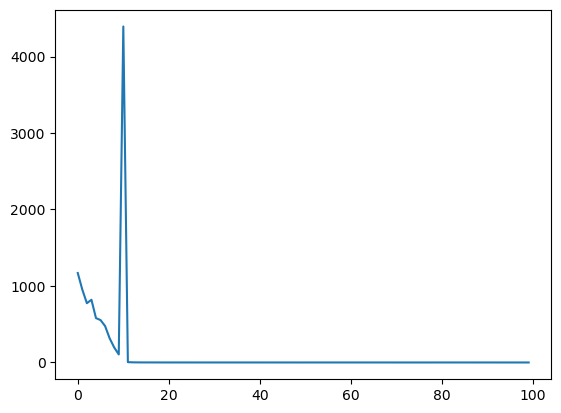

In [18]:
import matplotlib.pyplot as plt

plt.plot(evals[0]['accuracy_OLS_driver=None'])

print(evals[0]["accuracy_OLS_driver=None"])

plt.show()